Bailey Griswold  
2/6/2018  
Analyzing my phone use habits using the methods outlined in Cam Davidson-Pilon's Bayesian Methods for Hackers which can be found at: [github/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers).  Data was collected using the [Moment app](https://inthemoment.io/) on my phone and exported as a json file.


In [80]:
import numpy as np
import pandas as pd
import json
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

### 1. Load and visualize phone use data

In [40]:
with open('data/moment.json') as js:
     use_data = json.load(js)

In [41]:
#use_data.keys()

dict_keys(['days'])

In [43]:
#use_data['days'][0].keys()

dict_keys(['sessions', 'minuteCount', 'pickupCount', 'pickups', 'appUsages', 'date'])

In [44]:
#use_data['days'][3]['appUsages']

[{'appName': 'Instagram', 'onScreen': 43},
 {'appName': 'Facebook', 'onScreen': 26},
 {'appName': 'Twitter', 'onScreen': 26},
 {'appName': 'Home & Lock Screen', 'onScreen': 24},
 {'appName': 'Messages', 'onScreen': 22},
 {'appName': 'Phone', 'onScreen': 14},
 {'appName': 'Safari', 'onScreen': 13},
 {'appName': 'Gmail', 'onScreen': 8},
 {'appName': 'Chrome', 'onScreen': 6},
 {'appName': 'WhatsApp', 'onScreen': 3},
 {'appName': 'Google Maps', 'onScreen': 3},
 {'appName': 'Messenger', 'onScreen': 1},
 {'appName': 'Google Calendar', 'onScreen': 1},
 {'appName': 'Podcasts', 'onScreen': 0},
 {'appName': 'Moment', 'onScreen': 0},
 {'appName': 'Play Music', 'onScreen': 0},
 {'appName': 'Weather', 'onScreen': 0}]

In [54]:
for i in use_data['days']:
    del i['pickups']
    del i['appUsages']
    del i['sessions']

In [117]:
use_df = pd.DataFrame(use_data['days'])

In [118]:
use_df.head()

,date,minuteCount,pickupCount
0,2018-02-06T00:00:00-05:00,9,6
1,2018-02-05T00:00:00-05:00,105,42
2,2018-02-04T00:00:00-05:00,90,26
3,2018-02-03T00:00:00-05:00,143,43
4,2018-02-02T00:00:00-05:00,95,39


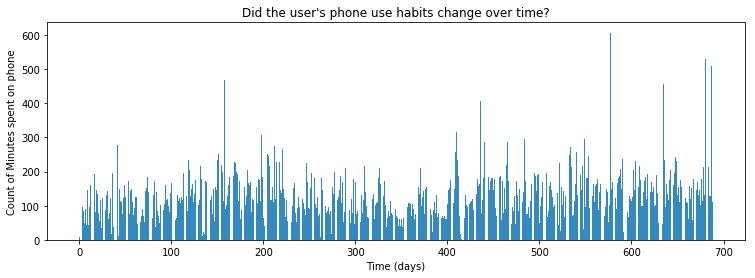

In [82]:
figsize(12.5, 4)

n_uses = len(use_df)
plt.bar(np.arange(n_uses), use_df.minuteCount, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("Count of Minutes spent on phone")
plt.title("Did the user's phone use habits change over time?")


### 2. Use PyMC3

In [74]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/use_df.minuteCount.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_uses - 1)

In [75]:
with model:
    idx = np.arange(n_uses) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [76]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=use_df.minuteCount)

In [77]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
100%|██████████| 15000/15000 [00:09<00:00, 1572.16it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [78]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

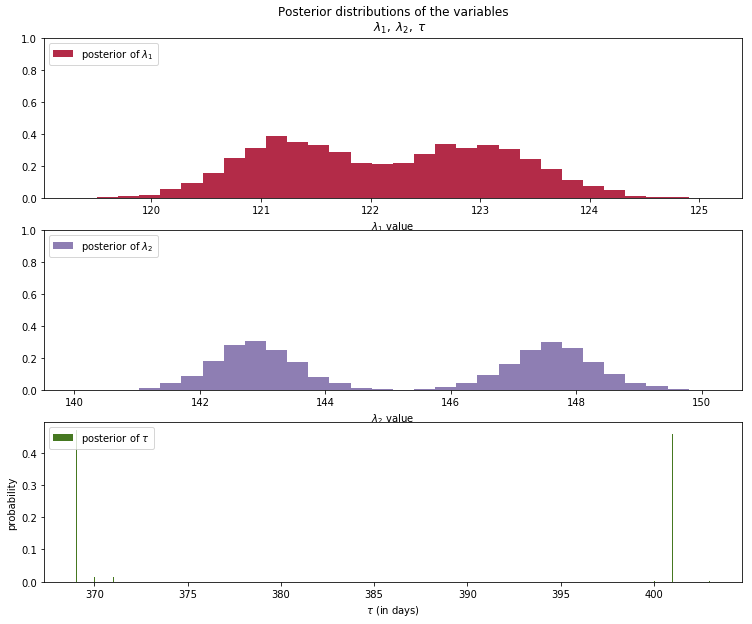

In [94]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
#plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_uses, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
#plt.xticks(np.arange(n_uses))

plt.legend(loc="upper left")
#plt.ylim([0, .75])
#plt.xlim([35, (n_uses - 20)])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

### 3. Comparing pick ups and minute count

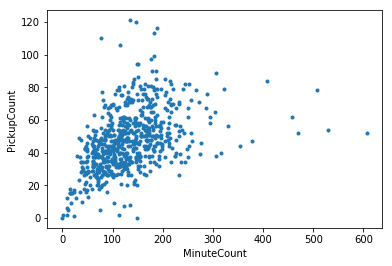

In [101]:
figsize(6,4)
plt.plot(use_df.minuteCount, use_df.pickupCount, '.')
plt.xlabel('MinuteCount')
plt.ylabel('PickupCount')

In [119]:
use_df.date = pd.to_datetime(use_df.date)

In [120]:
#Monday = 0, Sunday=6
use_df['dayofweek'] = [x.dayofweek for x in use_df.date]

<Container object of 7 artists>

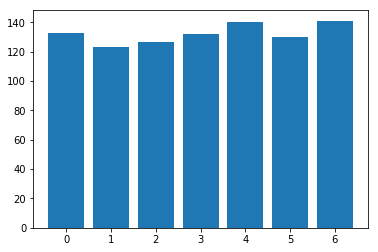

In [148]:
plt.bar(use_df.groupby('dayofweek')['minuteCount'].mean().index, height=use_df.groupby('dayofweek')['minuteCount'].mean())